# Preparations

In [1]:
import torch
import torchvision
import os.path

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn import manifold
from math import exp, sqrt
from torch.autograd import Variable
from my_dataset import MNIST_M
from my_dataset import ST_Dataset

%matplotlib inline
%load_ext skip_kernel_extension

In [2]:
use_gpu = torch.cuda.is_available()
print("use_gpu = " + str(use_gpu))

use_gpu = True


# SYNNUM Dataset

In [3]:
from my_dataset import SYNNUM

In [4]:
import torchvision
import torchvision.transforms as transforms

root_dir = "./data/"

transform_m = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

trainset_syn = SYNNUM(root_dir, train=True, transform=transform_m, download=True)
trainloader_syn = torch.utils.data.DataLoader(trainset_syn, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
testset_syn = SYNNUM(root_dir, train=False, transform=transform_m, download=True)
testloader_syn = torch.utils.data.DataLoader(testset_syn, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The 14th image in the first 128 images in the training set:


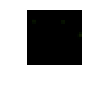

Its correspondent label:
tensor(7)


In [5]:
# randomly plot a sample from training set
import matplotlib.pyplot as plt

inputs = None
labels = None
for i, data in enumerate(trainloader_syn):
    inputs, labels = data
    break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(inputs[idx].permute(1, 2, 0).numpy())
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

In [6]:
len(trainset_syn)

479400

# SVHN Dataset

In [7]:
import torchvision
import os.path

root_dir = "./data/"
data_dir = "svhn/"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 128

trainset_svhn = torchvision.datasets.SVHN(os.path.join(root_dir, data_dir),
                                          split="train", transform=transform, download=True)
trainloader_svhn = torch.utils.data.DataLoader(trainset_svhn, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
testset_svhn = torchvision.datasets.SVHN(os.path.join(root_dir, data_dir),
                                          split="test", transform=transform, download=True)
testloader_svhn = torch.utils.data.DataLoader(testset_svhn, batch_size=batch_size,
                                          shuffle=False, num_workers=0)


Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The 72th image in the first 128 images in the training set:


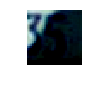

Its correspondent label:
tensor(5)


In [8]:
inputs = None
labels = None
for i, data in enumerate(trainloader_svhn):
    inputs, labels = data
    if i == 1:
        break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(inputs[idx].permute(1, 2, 0).numpy())
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

In [9]:
len(trainset_svhn)

73257

# Structure

![SVHN Structure](https://c1.staticflickr.com/1/907/41989310211_cb9d63bcc2_o.png)

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.C1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.C2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.C3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.FC1 = nn.Linear(128 * 7 * 7, 3072)
        self.FC2 = nn.Linear(3072, 2048)
        self.FC3 = nn.Linear(2048, 10)
        
    def forward(self, x):
        # C1
        x = F.relu(self.C1(x))
        # M1
        x = F.max_pool2d(x, (3, 3), stride=(2, 2))
        # C2
        x = F.relu(self.C2(x))
        # M2
        x = F.max_pool2d(x, (3, 3), stride=(2, 2))
        # C3
        x = F.relu(self.C3(x))
        # x's size is (128, 128, 7, 7)
        # flatten
        x = x.view(-1, 128 * 7 * 7)
        f = x
        # FC1
        x = F.relu(self.FC1(x))
        # FC2
        x = F.relu(self.FC2(x))
        lh = x
        # FC3
        x = self.FC3(x)
        return x, f, lh

In [32]:
cnn_syn = CNN()
if (use_gpu):
    cnn_syn.cuda()
print(cnn_syn)

CNN(
  (C1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (FC1): Linear(in_features=6272, out_features=3072, bias=True)
  (FC2): Linear(in_features=3072, out_features=2048, bias=True)
  (FC3): Linear(in_features=2048, out_features=10, bias=True)
)


In [33]:
def reset(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, sqrt(2 / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            size = m.weight.size()
            fan_out = size[0] # number of rows
            fan_in = size[1] # number of columns
            m.weight.data.normal_(0, sqrt(2 / (fan_in + fan_out)))
            m.bias.data.zero_()
        elif hasattr(m, 'reset_parameters'):
            m.reset_parameters()

# Training on SYNNUM

Or you can load the parameters directly.

In [34]:
import os.path
para_file = "./parameters/cnn_syn"
load_model = os.path.isfile(para_file)
print("load_model = " + str(load_model))

load_model = False


In [35]:
%%skip (not $load_model)
cnn_syn.load_state_dict(torch.load(para_file))

## Optimizer

In [36]:
import torch.optim as optim

lr_init = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_syn.parameters(), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Training process

In [37]:
#%%skip $load_model

prev_loss = np.float("inf")
total_epoch = 10
reset(cnn_syn)

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    adjust_lr(optimizer, p)
    for i, data in enumerate(trainloader_syn):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs, _, _ = cnn_syn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 300 == 299:    # print every 300 mini-batches
            print('[%4d] batch loss: %.3f' %
                  (i + 1, running_loss / 300))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        break
    else:
        prev_loss = epoch_loss

[ 300] batch loss: 0.608
[ 600] batch loss: 0.160
[ 900] batch loss: 0.122
[1200] batch loss: 0.098
[1500] batch loss: 0.081
[1800] batch loss: 0.070
[2100] batch loss: 0.064
[2400] batch loss: 0.051
[2700] batch loss: 0.051
[3000] batch loss: 0.048
[3300] batch loss: 0.048
[3600] batch loss: 0.044
epoch 1 loss: inf -> 439.908

[ 300] batch loss: 0.033
[ 600] batch loss: 0.026
[ 900] batch loss: 0.025
[1200] batch loss: 0.027
[1500] batch loss: 0.022
[1800] batch loss: 0.019
[2100] batch loss: 0.019
[2400] batch loss: 0.016
[2700] batch loss: 0.016
[3000] batch loss: 0.016
[3300] batch loss: 0.015
[3600] batch loss: 0.015
epoch 2 loss: 439.908 -> 76.717

[ 300] batch loss: 0.014
[ 600] batch loss: 0.012
[ 900] batch loss: 0.011
[1200] batch loss: 0.012
[1500] batch loss: 0.010
[1800] batch loss: 0.009
[2100] batch loss: 0.008
[2400] batch loss: 0.007
[2700] batch loss: 0.007
[3000] batch loss: 0.007
[3300] batch loss: 0.007
[3600] batch loss: 0.007
epoch 3 loss: 76.717 -> 34.329

[ 300

In [43]:
%%skip $load_model

torch.save(cnn_syn.state_dict(), para_file)

## Testing

In [38]:
def evaluate_accuracy(model, dataloader):
    correct = 0
    total = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        outputs, _, _ = model(inputs)
        correct += (torch.max(outputs.data, 1)[1] == labels.data).sum().item()
        total += labels.size()[0]
    acc = correct * 1.0 / total
    return acc

In [39]:
print("Accuracy on SYNNUM test set (source only): " + str(evaluate_accuracy(cnn_syn, testloader_syn)))

Accuracy on SYNNUM test set (source only): 0.9999415936587401


In [40]:
print("Accuracy on SVHN test set (source only): " + str(evaluate_accuracy(cnn_syn, testloader_svhn)))

Accuracy on SVHN test set (source only): 0.8795712968653965


# Training on SVHN

In [44]:
cnn_svhn = CNN()
if (use_gpu):
    cnn_svhn.cuda()
print(cnn_svhn)

CNN(
  (C1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (FC1): Linear(in_features=6272, out_features=3072, bias=True)
  (FC2): Linear(in_features=3072, out_features=2048, bias=True)
  (FC3): Linear(in_features=2048, out_features=10, bias=True)
)


In [45]:
para_file_svhn = "./parameters/cnn_svhn"
load_model_svhn = os.path.isfile(para_file_svhn)
print("load_model_svhn = " + str(load_model_svhn))

load_model_svhn = False


In [46]:
%%skip (not $load_model_svhn)
cnn_svhn.load_state_dict(torch.load(para_file_svhn))

## Optimizer

In [47]:
import torch.optim as optim

lr_init = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_svhn.parameters(), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Training Process

In [48]:
%%skip $load_model_svhn

prev_loss = np.float("inf")
total_epoch = 50
reset(cnn_svhn)

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    adjust_lr(optimizer, p)
    for i, data in enumerate(trainloader_svhn):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs, _, _ = cnn_svhn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%3d] batch loss: %.3f' %
                  (i + 1, running_loss / 50))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        break
    else:
        prev_loss = epoch_loss

[ 50] batch loss: 2.235
[100] batch loss: 1.943
[150] batch loss: 1.094
[200] batch loss: 0.783
[250] batch loss: 0.652
[300] batch loss: 0.581
[350] batch loss: 0.534
[400] batch loss: 0.466
[450] batch loss: 0.484
[500] batch loss: 0.442
[550] batch loss: 0.441
epoch 1 loss: inf -> 492.453

[ 50] batch loss: 0.399
[100] batch loss: 0.400
[150] batch loss: 0.370
[200] batch loss: 0.400
[250] batch loss: 0.365
[300] batch loss: 0.336
[350] batch loss: 0.328
[400] batch loss: 0.301
[450] batch loss: 0.320
[500] batch loss: 0.299
[550] batch loss: 0.308
epoch 2 loss: 492.453 -> 198.058

[ 50] batch loss: 0.286
[100] batch loss: 0.286
[150] batch loss: 0.267
[200] batch loss: 0.308
[250] batch loss: 0.272
[300] batch loss: 0.248
[350] batch loss: 0.247
[400] batch loss: 0.228
[450] batch loss: 0.244
[500] batch loss: 0.225
[550] batch loss: 0.238
epoch 3 loss: 198.058 -> 147.609

[ 50] batch loss: 0.228
[100] batch loss: 0.220
[150] batch loss: 0.212
[200] batch loss: 0.247
[250] batch lo

In [50]:
%%skip $load_model_svhn

torch.save(cnn_svhn.state_dict(), para_file_svhn)

In [49]:
print("Accuracy on SVHN test set (train on target): " + str(evaluate_accuracy(cnn_svhn, testloader_svhn)))

Accuracy on SVHN test set (train on target): 0.9270897357098955


# Unsupervised Domain Adaptation

## Join Source and Target Dataset

In [36]:
from my_dataset import ST_Dataset

In [46]:
batch_size = 128

trainset_da = ST_Dataset(trainset_syn, trainset_svhn, batch_size)
trainloader_da = torch.utils.data.DataLoader(trainset_da, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The 72th image in the first 128 images in the training set:


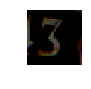

Its correspondent label:
I don't know :)

From domain:
Target


In [52]:
# randomly plot a sample from test set
import matplotlib.pyplot as plt

inputs = None
labels = None
for i, data in enumerate(trainloader_da):
    inputs, labels, domain = data
    if i == 2:
        break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(inputs[idx].permute(1, 2, 0).numpy())
plt.show()
print("Its correspondent label:")
if labels[idx].item() == -1:
    print("I don't know :)\n")
else:
    print(str(labels[idx].item()) + "\n")

print("From domain:")
if domain[idx].item() == 0:
    print("Source")
else:
    print("Target")

## GRL Layer

In [53]:
class GRL_func(torch.autograd.Function):

    @staticmethod
    def forward(ctx, inputs, lamda):
        ctx.save_for_backward(lamda)
        return inputs

    @staticmethod
    def backward(ctx, grad_outputs):
        lamda, = ctx.saved_tensors
        return -lamda * grad_outputs, None

In [54]:
class GRL(nn.Module):
    
    def __init__(self, lamda_init):
        super(GRL, self).__init__()
        self.GRL_func = GRL_func.apply
        self.lamda = nn.Parameter(torch.Tensor(1), requires_grad=False)
        self.set_lamda(lamda_init)
        
    def forward(self, x):
        return self.GRL_func(x, self.lamda)
    
    def set_lamda(self, lamda_new):
        self.lamda[0] = lamda_new

## Structure

![SVHN Structure](https://c1.staticflickr.com/1/907/41989310211_cb9d63bcc2_o.png)

In [67]:
class CNN_DA(nn.Module):
    
    def __init__(self, lamda_init=0):
        super(CNN_DA, self).__init__()
        # lamda
        self.lamda = lamda_init
        # feature extractor
        self.C1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.C2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.C3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        # label classifier
        self.LC_FC1 = nn.Linear(128 * 7 * 7, 3072)
        self.LC_FC2 = nn.Linear(3072, 2048)
        self.LC_FC3 = nn.Linear(2048, 10)
        # domain classifier
        self.GRL_layer = GRL(lamda_init)
        self.DC_FC1 = nn.Linear(128 * 7 * 7, 1024)
        self.DC_FC2 = nn.Linear(1024, 1024)
        self.DC_FC3 = nn.Linear(1024, 1)
        
    def forward(self, x):
        # C1
        x = F.relu(self.C1(x))
        # M1
        x = F.max_pool2d(x, (3, 3), stride=(2, 2))
        # C2
        x = F.relu(self.C2(x))
        # M2
        x = F.max_pool2d(x, (3, 3), stride=(2, 2))
        # C3
        x = F.relu(self.C3(x))
        # x's size is (128, 128, 7, 7)
        # flatten
        x = x.view(-1, 128 * 7 * 7)
        f = x
        # label classifier
        # LC_FC1
        x_l = F.relu(self.LC_FC1(x))
        # LC_FC2
        x_l = F.relu(self.LC_FC2(x_l))
        lh = x_l
        # LC_FC3
        x_l = self.LC_FC3(x_l)
        # domain classifier
        # GRL
        x_d = self.GRL_layer(x)
        # DC_FC1
        x_d = F.relu(self.DC_FC1(x_d))
        # DC_FC2
        x_d = F.relu(self.DC_FC2(x_d))
        # DC_FC3
        x_d = F.sigmoid(self.DC_FC3(x_d))
        return x_l, x_d, f, lh
    
    def set_lamda(self, lamda_new):
        self.GRL_layer.set_lamda(lamda_new)

In [68]:
cnn_da = CNN_DA(0)
if (use_gpu):
    cnn_da.cuda()
print(cnn_da)

CNN_DA(
  (C1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (C2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (C3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (LC_FC1): Linear(in_features=1024, out_features=3072, bias=True)
  (LC_FC2): Linear(in_features=3072, out_features=2048, bias=True)
  (LC_FC3): Linear(in_features=2048, out_features=10, bias=True)
  (GRL_layer): GRL()
  (DC_FC1): Linear(in_features=1024, out_features=1024, bias=True)
  (DC_FC2): Linear(in_features=1024, out_features=1024, bias=True)
  (DC_FC3): Linear(in_features=1024, out_features=1, bias=True)
)


In [69]:
para_file_da = "./parameters/cnn_syn_to_svhn"
load_model_da = os.path.isfile(para_file_da)
print("load_model_da = " + str(load_model_da))

load_model_da = False


In [70]:
%%skip (not $load_model_da)
cnn.load_state_dict(torch.load(para_file_da))

### Optimizer

In [71]:
from math import exp

lr_init = 0.01
criterion_LC = nn.CrossEntropyLoss()
criterion_DC = nn.BCELoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_da.parameters()), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr
        
def adjust_lamda(model, p):
    gamma = 10
    lamda = 2 / (1 + exp(- gamma * p)) - 1
    model.set_lamda(lamda)
    return lamda

### Training process

In [73]:
#%%skip $load_model_da

prev_loss = np.float("inf")
total_epoch = 50
reset(cnn_da)

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    adjust_lr(optimizer, p)
    lamda = adjust_lamda(cnn_da, p)
    for i, data in enumerate(trainloader_da):
        source_size = data[0].size()[0] // 2
        inputs, labels, domains = data
        domains = domains.to(torch.float32)
        if (use_gpu):
            inputs, labels, domains = inputs.cuda(), labels.cuda(), domains.cuda()
        inputs, labels, domains = Variable(inputs), Variable(labels), Variable(domains)
        optimizer.zero_grad()
        outputs_LC, outputs_DC, _, _ = cnn_da(inputs)
        outputs_DC = outputs_DC.view(-1)
        loss_LC = criterion_LC(outputs_LC[:source_size], labels[:source_size])
        loss_DC = criterion_DC(outputs_DC, domains)
        loss = loss_LC + loss_DC
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%3d] batch loss: %.3f' %
                  (i + 1, running_loss / 50))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        prev_loss = epoch_loss
        pass
    else:
        prev_loss = epoch_loss

RuntimeError: Expected tensor for argument #1 'input' to have the same dimension as tensor for 'result'; but 4 does not equal 2 (while checking arguments for cudnn_convolution)

In [39]:
%%skip $load_model_da

torch.save(cnn.state_dict(), para_file_da)

In [40]:
def evaluate_da_accuracy(model, dataloader):
    correct = 0
    total = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        outputs_LC, _ = model(inputs)
        correct += (torch.max(outputs_LC.data, 1)[1] == labels.data).sum().item()
        total += labels.size()[0]
    acc = correct * 1.0 / total
    return acc

In [42]:
print("Accuracy on MNIST-M test set (source only): " + str(evaluate_da_accuracy(cnn_da, testloader_m)))

Accuracy on MNIST-M test set (source only): 0.8186666666666667
